<a href="https://colab.research.google.com/github/orekhovsky/ITMO_Masters/blob/main/Introduction%20%26%20Advanced%20ML/Clustering/Clustering_Palette_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Использование `K-means` для сжатия


Еще одно полезное применение кластеризации — сжатие изображений. Схема до удивления проста: похожие, рядом расположенные цвета, стоит объединить в один цвет. Давайте провернем это самостоятельно.

Считайте изображение из вашего индивидуального задания.

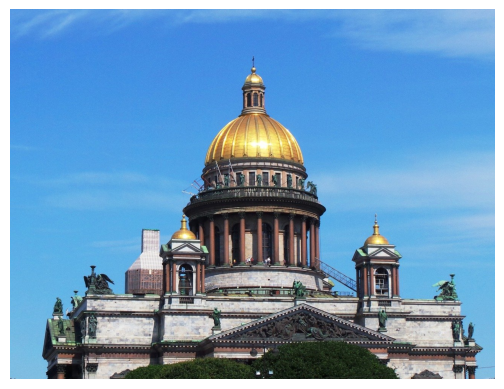

In [1]:
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np


# Путь к изображению
img_path = '/content/spb_st_isaacs_2.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

Перед нами трехканальное (RGB) изображение. Вычислите среднее значение интенсивности пикселей по всем каналам.

In [2]:
# Разделение изображения на каналы
b, g, r = cv2.split(img)

# Усреднение интенсивности пикселей по всем каналам
mean_intensity = np.mean(img)

print(f'Среднее значение интенсивности пикселей по всем каналам: {mean_intensity}')

Среднее значение интенсивности пикселей по всем каналам: 140.9997785391052


Нормируйте значения интенсивностей пикселей, разделив все значения на $255$. Вычислите среднее значение интенсивности пикселей по всем каналам после проделанного преобразования.

In [3]:
# Нормирование значений интенсивности пикселей, разделив на 255
normalized_image = img / 255.0

# Вычисление среднего значения интенсивности пикселей по всем каналам
mean_intensity_normalized = np.mean(normalized_image)

print(f'Среднее значение интенсивности пикселей по всем каналам после нормирования: {mean_intensity_normalized}')


Среднее значение интенсивности пикселей по всем каналам после нормирования: 0.552940307996491


Давайте убедимся в том, что исходное пространство цветов, насчитывающее около $16$ миллионов возможных состояний ($256^3$), слишком велико, и его размерность можно понижать. Для наглядности построим лишь некоторые подвыборки зависимостей значений интенсивностей и лишь на случайном поднаборе пикселей.

«Распрямите» изображение так, чтобы <code>.shape</code> соответствущего массива имел вид <code>(высота * ширина, 3)</code>

In [4]:
# Функция принимает на вход "распрямленный" массив, соответствующий изображению

def plot_pixels(data, colors=None, N=10000):
    if colors is None:
        colors = data

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

In [5]:
# Получение высоты и ширины изображения
height, width, channels = normalized_image.shape

# Распрямление изображения в массив с формой (высота * ширина, 3)
flattened_image = normalized_image.reshape(-1, 3)

# flattened_image теперь имеет форму (высота * ширина, 3)

# Проверка новой формы массива
print(f'Форма "распрямленного" изображения: {flattened_image.shape}')
print(height, width)

Форма "распрямленного" изображения: (1249280, 3)
976 1280


Переведем 16 миллионов возможностей во всего-навсего 16 возможностей, используя <code>K-means</code>. Правда, чтобы ускорить работу алгоритма, мы будем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html"><code>K-means</code> на батчах</a> — поднаборах данных. Заодно увидим, портит ли это результат.

Обучите модель <code>MiniBatchKMeans</code> на нормированном и «распрямленном» изображении с параметрами, указанными в вашем задании.

В изображении замените значения цветов каждого пикселя на значения координат центроида кластера к которому был отнесен этот пиксель. Постройте графики зависимостей цветов при помощи <code>plot_pixels()</code> с новой палитрой (параметр <code>colors</code>)


In [6]:
from sklearn.cluster import MiniBatchKMeans
# Создание и обучение модели MiniBatchKMeans
n_clusters = 16
random_state = 10
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
kmeans.fit(flattened_image)

# Замена значений цветов каждого пикселя на значения координат центроида кластера
labels = kmeans.predict(flattened_image)
new_image = kmeans.cluster_centers_[labels].reshape(height, width, channels)

Вычислите среднее значение интенсивности пикселей полученного изображения.

In [7]:
# Вычисление среднего значения интенсивности пикселей полученного изображения
mean_intensity = np.mean(new_image)

# Вывод результата
print(f"Среднее значение интенсивности пикселей: {mean_intensity}")

Среднее значение интенсивности пикселей: 0.5532844302728643


Выберите номер изображения, соответствующего палитре из $16$ цветов.

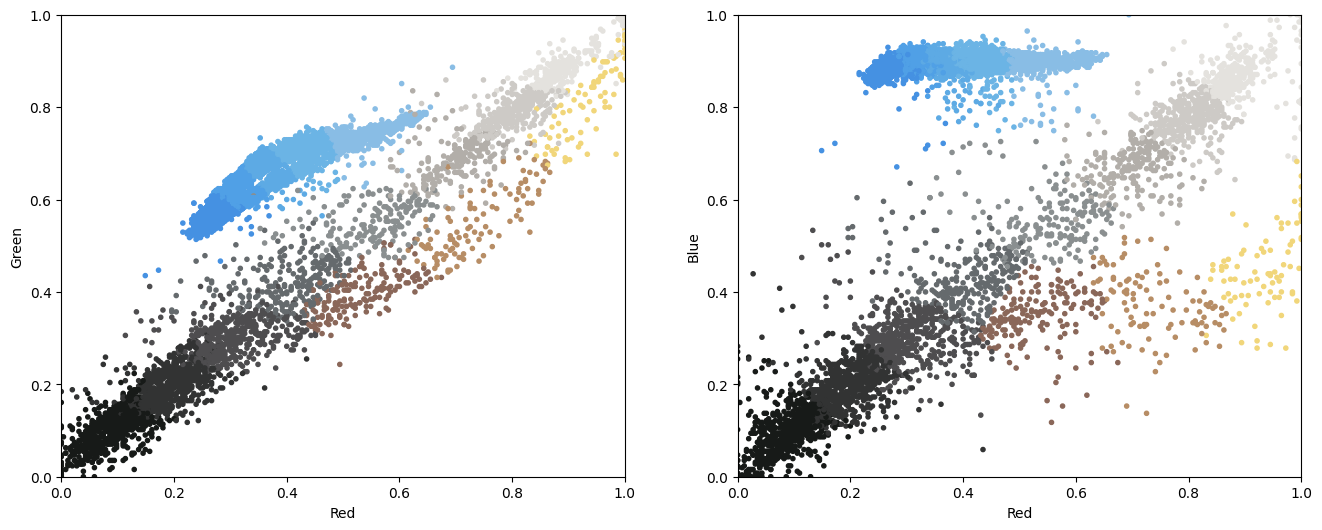

In [8]:
plot_pixels(flattened_image, colors=kmeans.cluster_centers_[kmeans.labels_])

Пора смотреть на результат! Постройте рядом оригинальное изображение и изображение, в котором используется лишь $16$ цветов.

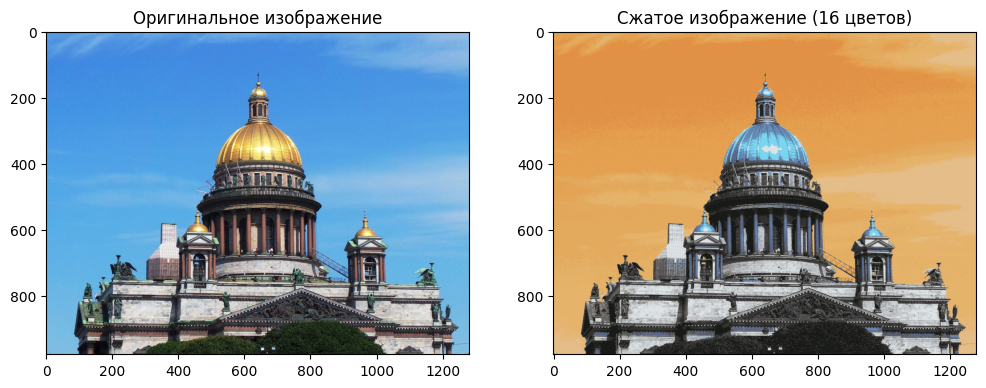

In [9]:
new_image = new_image *255.0
new_image = new_image.astype(np.uint8)

orig_image = cv2.imread(img_path)

# Построение рядом оригинального и сжатого изображений
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Оригинальное изображение')

axes[1].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Сжатое изображение (16 цветов)')
plt.show()

Постройте изображение размера $4 \times 4$ на основе полученных $16$ цветов. Выберите верное изображение.

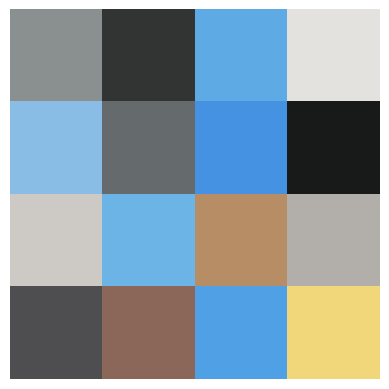

In [10]:
# Создание матрицы 4x4 с индексами цветов
color_indices = np.array([[0, 1, 2, 3],
                          [4, 5, 6, 7],
                          [8, 9, 10, 11],
                          [12, 13, 14, 15]])

# Цвета, соответствующие индексам
colors = kmeans.cluster_centers_

# Создание изображения на основе цветов
small_image = colors[color_indices]

# Преобразование изображения в целые значения
small_image = np.round(small_image * 255.0).astype(int)

# Отображение изображения

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(small_image)
plt.show()